# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/) compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

## Exploring the data

In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

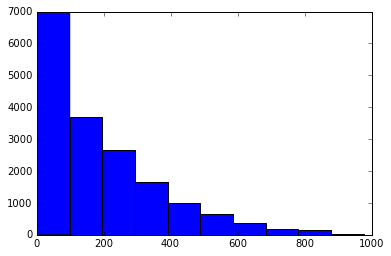

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bike_rentals['cnt'])

The column **cnt** which is the total number of bike rentals has a skewed distribution.

In [3]:
# correlation between 'cnt' and other columns
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

We can see that 'cnt' is highly correlated to 'casual' and 'registered', that's because cnt = casual + registred

## Creating new features

The **hr** column in **bike_rentals** contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for **morning**, **afternoon**, **evening**, and **night**. This will bundle similar times together, enabling the model to make better decisions.

In [4]:
def assign_label(hour):
    if hour>=6 and hour<12:
        return 1
    if hour>=12 and hour<18:
        return 2
    if hour>=18 and hour<24:
        return 3
    if hour>=0 and hour<6:
        return 4

In [5]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

### Error Metric

To test our model, I'm going to use the mean squared error since it works on contunuous numeric data.

## Split the data

In [6]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Linear Regression

In [10]:
# choose features that don't give away information about the target
features = [c for c in train.columns if not c in ['cnt', 'casual', 'dteday', 'registered']]
features

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[features], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
predictions = lr.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])

In [13]:
mse

17355.03601884258

## Decision Trees

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(train[features], train['cnt'])
predictions = tree.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
mse

3400.554085155351

Let's experiment with other parameters.

In [20]:
tree = DecisionTreeRegressor(min_samples_leaf=5)
tree.fit(train[features], train['cnt'])
predictions = tree.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
mse

2658.7828943201407

In [23]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(train[features], train['cnt'])
predictions = tree.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
mse

11556.966982655524

In [25]:
tree = DecisionTreeRegressor(min_samples_leaf=5, 
                             max_depth=3)
tree.fit(train[features], train['cnt'])
predictions = tree.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
mse

15990.309819082107

The default decisio tree model already performed better than linear regression. Tweaking the **min_samples_leaf** parameter improved it even more.

## Random Forest Algorithm

In [26]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(train[features], train['cnt'])
predictions = forest.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
mse

1813.5567779056387

It outperformed both models. Let's experiment with other parameters.

In [28]:
forest = RandomForestRegressor(min_samples_leaf=5)
forest.fit(train[features], train['cnt'])
predictions = forest.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
mse

1997.479533318578

In [29]:
forest = RandomForestRegressor(min_samples_leaf=3)
forest.fit(train[features], train['cnt'])
predictions = forest.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
mse

1928.6938286195884

The default model performs the best.